## Review Analysis

In this demonstraton, we will explore feedback on Moscow railway stations that users left on Yandex Maps.

We will first show how to use a model from HuggingFace, so you may want to use GPU-enabled compute in the Datasphere.

First, let's install some libraries:

In [ ]:
%pip install transformers yandex-cloud-ml-sdk

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 44.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 67.1 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Getting the Dataset

We will donwload the dataset with reviews translated into English:

In [1]:
import pandas as pd
df = pd.read_csv("https://storage.yandexcloud.net/mypub/data/rail_reviews_en.zip")
df

,id,dislike,like,review_text,author,review_rating,datetime,station
0,1251,1,10,"It's a very beautiful place, and the staff are...",Александра Подгайская,5,2024-01-12T16:53:33.611Z,Belorussky
1,1252,0,5,"It's located very conveniently, new routes are...",Пользователь Э.,5,2023-11-10T21:33:56.176Z,Belorussky
2,1253,2,7,This station is very cozy and convenient. I re...,Н И,5,2023-08-25T14:27:29.327Z,Belorussky
3,1254,1,5,"It's a beautiful building, very conveniently l...",Liliya Zugrova,5,2023-11-27T11:50:16.388Z,Belorussky
4,1255,2,7,"With the appearance of new lines and routes, e...",Татьяна Цымлова,5,2023-11-25T06:43:16.558Z,Belorussky
...,...,...,...,...,...,...,...,...
2264,2266,0,1,"Excellent station. New and modern, with direct...",Анна Елагина,5,2024-02-02T04:55:15.074Z,Vostochny
2265,2267,1,0,I've been there recently)) the cuisine is real...,Дмитрий,5,2023-11-12T14:21:47.541Z,Vostochny
2266,2268,0,0,It's a great and beautiful station. The toilet...,Валентина Архимановна,5,2024-01-31T10:53:36.364Z,Vostochny
2267,2269,3,10,"This is not a train station, but rather a hub ...",Владислав Баранов,2,2023-12-06T12:03:14.107Z,Vostochny


Let's look at the number of feedback for each railway station:

<Axes: xlabel='station'>

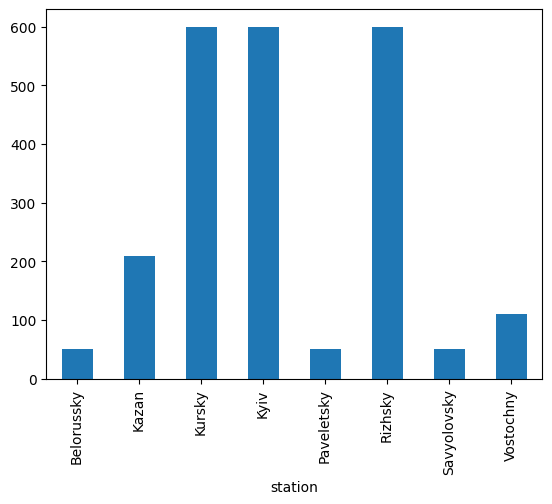

In [2]:
df.groupby('station')['review_text'].count().plot.bar()

### Enriching data with Sentiment using HuggingFace model

We can use any sentiment analysis model from HuggingFace, for example, [tabularisai/multilingual-sentiment-analysis](https://huggingface.co/tabularisai/multilingual-sentiment-analysis). You can see the sample code in the model card page:

In [3]:
from transformers import pipeline

# Load the classification pipeline with the specified model
pipe = pipeline("text-classification", model="tabularisai/multilingual-sentiment-analysis")

# Classify a new sentence
sentence = "I love this product! It's amazing and works perfectly."
result = pipe(sentence)

# Print the result
print(result)


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-07-12 09:53:28.257015: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 09:53:34.056665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-12 09:53:47.696422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist

[{'label': 'Very Positive', 'score': 0.5922620892524719}]


Let's map sentiment in a number, so that it is easier to process. We will also explicitly limit the number of characters in a review to 512, which is the limit of the model:

In [12]:
sentiment_map = {"Very Negative" : -2, "Negative" : -1, "Neutral" : 0, "Positive" : 1, "Very Positive" : 2}

def predict(x):
    if isinstance(x,list):
        x = [z[:512] for z in x]
    else:
        x = x[:512]
    return [ sentiment_map[z['label']] for z in pipe(x)]

Let's check this function:

In [10]:
predict([
    'It is an ordinary railway station...',
    'I love this station, trains are very colorful!',
    'I hate this awful station, most of the time trains are 20 min late'])

[0, 2, -2]

To apply this function to the whole dataset, we will split it into smaller parts:

In [14]:
from tqdm.auto import tqdm
import numpy as np 

res = []
for d in tqdm(np.array_split(df,10)):
    z = list(d['review_text'])
    p = predict(z)
    res.extend(p)
df['hf_sentiment'] = res

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Let's store this to disk just in case:

In [15]:
df.to_csv('dataset_with_hf_sentiment.csv',index=False)

Now let's see most positive and most negative stations in Moscow:

In [17]:
def count_pos(x):
    return x[x==1].count()
def count_neg(x):
    return x[x==-1].count()


df.groupby('station').agg({'hf_sentiment' : ['mean', count_pos, count_neg ], 'review_text': 'count'})

hf_sentiment                     review_text
                    mean count_pos count_neg       count
station                                                 
Belorussky      0.860000        13         0          50
Kazan           0.842857        53        10         210
Kursky          0.406667       118        46         600
Kyiv            0.652755       111        22         599
Paveletsky      0.620000        11         2          50
Rizhsky         0.611667       117        32         600
Savyolovsky     0.480000        13         1          50
Vostochny       0.554545        28         9         110

At this point, you can stop your GPU machine and switch to CPU-only **c1.4**

### Using YandexGPT to extract meaning from feedback

Let's try to use LLMs to extract structured information from unstructured text. We will use [Yandex Cloud ML SDK](https://yandex.cloud/ru/docs/foundation-models/quickstart/yandexgpthttps://yandex.cloud/ru/docs/foundation-models/quickstart/yandexgpt) in order to call YandexGPT model in the cloud.

In order to use Cloud APIs, we need `api_key` and `folder_id`. You can obtain those by creating service account in Yandex Cloud Console, giving it some permissions, and then setting API key. It is convenient to store those values as DataSphere secrets.

In [18]:
import os

folder_id = os.environ['folder_id']
api_key = os.environ['api_key']
print(f"Using folder {folder_id}")

Using folder b1gbicod0scglhd49qs0


Let's make a function for calling YandexGPT:

In [21]:
from yandex_cloud_ml_sdk import YCloudML

sdk = YCloudML(folder_id=folder_id,auth=api_key)

def gpt(messages,
        system_message=None,
        model="yandexgpt", model_version="rc",
        return_text=True,
        return_json=False):
    if isinstance(messages,str):
        messages = [{ "role" : "user", "text" : messages }]
        if system_message is not None:
            messages.insert(0, { "role" : "system", "text" : system_message })
    model = sdk.models.completions(model,model_version=model_version)
    if return_json:
        model = model.configure(response_format='json')
    res = model.run(messages)
    res = res.alternatives[0]
    return res.text if return_text else res

gpt("Tell us a joke about JSON and XML")

'Why did the developer use JSON instead of XML? Because he didn\'t want to deal with all those "angle-tastic" complications!'

To speed up our demo, let's sample 10 reviews for each railway station:

In [22]:
import pandas as pd

df = pd.read_csv('dataset_with_hf_sentiment.csv')
df_sample = df.groupby('station').apply(lambda x: x.sample(10)).reset_index(drop=True)
df_sample

,id,dislike,like,review_text,author,review_rating,datetime,station,hf_sentiment
0,1300,7,21,"It's conveniently located, there are storage l...",Люси,5,2023-04-05T23:12:23.159Z,Belorussky,0
1,1262,2,16,В интернете есть много сайтов с информацией на...,Алекс,5,2023-04-22T16:43:05.097Z,Belorussky,0
2,1299,4,9,The station building itself is beautiful. Ther...,Григорий Николаевич,4,2023-11-09T17:07:07.324Z,Belorussky,2
3,1298,0,0,"Beautiful, convenient, comfortable. You can ge...",Елена Маркина,5,2023-12-15T16:17:31.269Z,Belorussky,2
4,1296,1,0,This is my favorite station. Everything is cle...,Елена Павлова,5,2023-08-11T13:49:03.744Z,Belorussky,0
...,...,...,...,...,...,...,...,...,...
75,2236,1,5,"Excellent station, clean, the decoration seems...",Алексей,5,2024-02-08T15:46:52.258Z,Vostochny,1
76,2229,2,3,"It's a good, modern station. It's quite conven...",Александр Баранов,5,2023-11-13T18:20:44.039Z,Vostochny,1
77,2170,0,0,A new and slightly unconventional station! I r...,Анастасия,5,2023-12-04T11:04:24.847Z,Vostochny,2
78,2254,2,3,It's a good station with a convenient exit fro...,Алсу Р,5,2023-12-31T14:36:25.010Z,Vostochny,1


We will now try to extract more detailed feedback about different aspects using prompt:

In [24]:
prompt = """
Read the review about a railway station given below in triple backquotes: ````{}```.
You need to extract the following information from this feedback:
* sentiment - a number from -2 to 2, starting from very negative (-2), up to very positive (2)
* transport - how easy it is to get there, on the scale 1..5, if the review contains this information. If not - 0
* cleanliness - how clean is the station, on the scale 1..5, if the review contains this information. If not - 0
* schedule - are the trains on schedule, on the scale 1..5, if the review contains this information. If not - 0
* positive - short list of positive things from the review
* negative - short list of negative things from the review
* tags - short list of tags for the review, giving info on what aspects are mentioned
You need to return the result as JSON in this format:
{{
  "sentiment" : ...,
  "transport" : ...,
  "cleanliness" : ...,
  "schedule" : ...,
  "positive" : ["...", ...],
  "negative" : ["...", ...],
  "tags" : ["..."]
}}
"""

txt = df['review_text'].iloc[0]
print(txt)
res = gpt(prompt.format(txt))
res

It's a very beautiful place, and the staff are polite.

I traveled by train from Moscow to Belarus. It was comfortable: clean linen, warm, and you can travel with pets. They even serve hot tea right to your bed, so you don't have to exert yourself. The qualified staff take care of everything and ensure your comfort.


'```\n{\n  "sentiment": 2,\n  "transport": 0,\n  "cleanliness": 0,\n  "schedule": 0,\n  "positive": ["beautiful place", "polite staff", "comfortable", "clean linen", "warm", "can travel with pets", "hot tea service"],\n  "negative": [],\n  "tags": ["staff", "comfort", "service"]\n}\n```'

To guarantee that result is returned as JSON, we will use so-called **structured output**. In our`gpt` function we have `return_json` parameter, which restricts model output to valid json. We could also be even more specific and define pydantic schema object with specific fields, and require model to return fields with correct names and of correct type.

In [25]:
import json 

txt = df['review_text'].iloc[0]
print(txt)
res = json.loads(gpt(prompt.format(txt),return_json=True))
res

It's a very beautiful place, and the staff are polite.

I traveled by train from Moscow to Belarus. It was comfortable: clean linen, warm, and you can travel with pets. They even serve hot tea right to your bed, so you don't have to exert yourself. The qualified staff take care of everything and ensure your comfort.


{'sentiment': 2,
 'transport': 0,
 'cleanliness': 0,
 'schedule': 0,
 'positive': ['beautiful place',
  'polite staff',
  'comfortable',
  'clean linen',
  'warm',
  'can travel with pets',
  'hot tea service',
  'qualified staff'],
 'negative': [],
 'tags': ['beauty', 'staff', 'comfort', 'service']}

Now let's extract information from all columns using GPT:

In [26]:
from tqdm.auto import tqdm
import numpy as np

for f in ["sentiment","transport","cleanliness", "schedule", "positive", "negative", "tags"]:
    df_sample[f]=np.nan

def lin(x):
    if isinstance(x,list):
        return ','.join(x)
    elif isinstance(x,float):
        return ''
    else:
        return x
    
for i,r in tqdm(df_sample.iterrows(),total=len(df_sample)):
    txt = r['review_text']
    if not pd.isnull(r['positive']):
        continue # уже распознано
    try:
        res = gpt(prompt.format(txt),return_json=True)
        res = json.loads(res)
        for f in ["sentiment","transport","cleanliness", "schedule", "positive", "negative", "tags"]:
            df_sample.at[i,f] = lin(res[f])
    except Exception as e:
        print(f'Error: {e}, response is {res}, text={txt}')
        df_sample.at[i,'sentiment'] = 0
        df_sample.at[i,'positive'] = ''
        df_sample.at[i,'negative'] = ''

100%|██████████| 80/80 [01:24<00:00,  1.06s/it]


Let's save the result, and look at it:

In [27]:
df_sample.to_csv('dataset_sample_with_GPT.csv',index=False)

In [28]:
df_sample = pd.read_csv('dataset_sample_with_GPT.csv')
df_sample

,id,dislike,like,review_text,author,review_rating,datetime,station,hf_sentiment,sentiment,transport,cleanliness,schedule,positive,negative,tags
0,1300,7,21,"It's conveniently located, there are storage l...",Люси,5,2023-04-05T23:12:23.159Z,Belorussky,0,2.0,5.0,0.0,0.0,"convenient location,storage lockers,cheap meal...","expensive prices at GUM,almost no people at GUM","location,transport,food,shopping"
1,1262,2,16,В интернете есть много сайтов с информацией на...,Алекс,5,2023-04-22T16:43:05.097Z,Belorussky,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,1299,4,9,The station building itself is beautiful. Ther...,Григорий Николаевич,4,2023-11-09T17:07:07.324Z,Belorussky,2,1.0,5.0,5.0,0.0,"beautiful station building,convenient exit fro...","ongoing renovations,inconvenient transfer to t...","station building,accessibility,food,security,r..."
3,1298,0,0,"Beautiful, convenient, comfortable. You can ge...",Елена Маркина,5,2023-12-15T16:17:31.269Z,Belorussky,2,2.0,5.0,0.0,5.0,"beautiful,convenient,comfortable,easy access t...",NaN,"Aeroexpress,Sheremetyevo Airport,waiting room"
4,1296,1,0,This is my favorite station. Everything is cle...,Елена Павлова,5,2023-08-11T13:49:03.744Z,Belorussky,0,2.0,5.0,0.0,0.0,"favorite station,convenient location,two metro...",temporary inconvenience due to improvements,"location,transport,shops,cafes,ticket offices,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2236,1,5,"Excellent station, clean, the decoration seems...",Алексей,5,2024-02-08T15:46:52.258Z,Vostochny,1,2.0,5.0,5.0,0.0,"excellent station,clean,convenient location,fr...",NaN,"cleanliness,location,staff"
76,2229,2,3,"It's a good, modern station. It's quite conven...",Александр Баранов,5,2023-11-13T18:20:44.039Z,Vostochny,1,2.0,0.0,0.0,0.0,"modern station,convenient,separate exit for ea...",NaN,"convenience,infrastructure"
77,2170,0,0,A new and slightly unconventional station! I r...,Анастасия,5,2023-12-04T11:04:24.847Z,Vostochny,2,2.0,0.0,5.0,0.0,"new,visually appealing,warm,comfortable,reason...",NaN,"visual appeal,comfort,food,cleanliness"
78,2254,2,3,It's a good station with a convenient exit fro...,Алсу Р,5,2023-12-31T14:36:25.010Z,Vostochny,1,2.0,5.0,5.0,0.0,"convenient exit from the metro,clean and well-...","not enough seating areas,no option to buy hot ...","metro,cleanliness,transport accessibility,seat..."


## Making conclusions

It is interesting to see if sentiment correlates between YandexGPT and HuggingFace model:

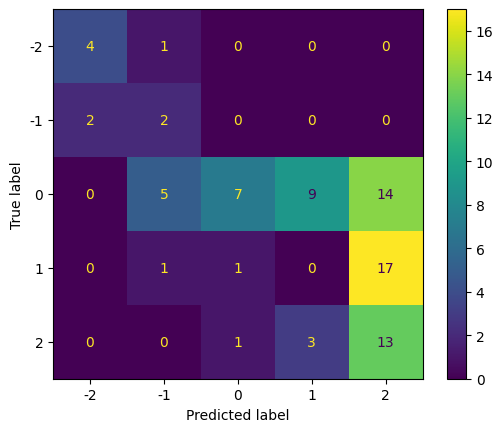

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(df_sample['hf_sentiment'],df_sample['sentiment'])

Let's see average sentiment by station:

In [30]:
for f in ["transport","cleanliness", "schedule"]:
    df_sample[f] = df_sample[f].apply(lambda x: np.nan if x==0 else x)

df_sample.groupby('station').agg( {'transport' : 'mean', 'cleanliness' : 'mean', 'schedule' : 'mean'})

,transport,cleanliness,schedule
station,,,
Belorussky,5.0,5.0,5.0
Kazan,4.4,4.4,NaN
Kursky,NaN,3.2,NaN
Kyiv,5.0,4.0,NaN
Paveletsky,5.0,3.0,NaN
Rizhsky,3.5,4.0,1.0
Savyolovsky,3.0,5.0,NaN
Vostochny,5.0,4.5,5.0


This can also be presented as a graph

<Axes: xlabel='station'>

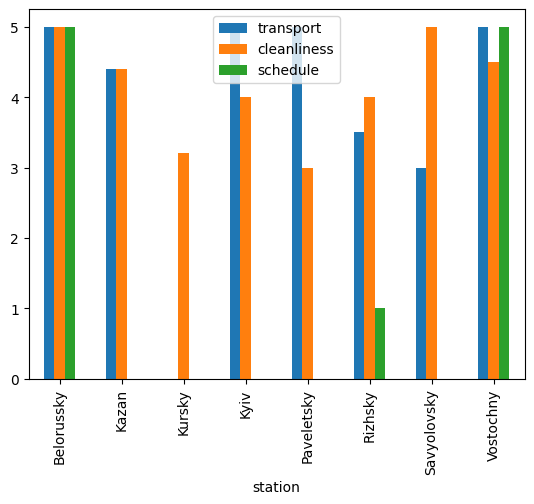

In [31]:
df_sample.groupby('station').agg(
    {'transport' : 'mean', 
     'cleanliness' : 'mean', 
     'schedule' : 'mean'}).plot.bar()

Now let's see the tags:

In [32]:
tags = list(df_sample['tags'].apply(lambda x: str(x).split(',')))
tags = set(sum(tags,[])) - { 'nan', '' }
tags

{'ATMs',
 'Aeroexpress',
 'Sheremetyevo Airport',
 'Troika card',
 'access',
 'accessibility',
 'amenities',
 'architecture',
 'atmosphere',
 'beauty',
 'boarding gates',
 'boarding platforms',
 'building',
 'cafe',
 'cafes',
 'catering',
 'charging options',
 'cleanliness',
 'closure',
 'coffee',
 'comfort',
 'comfort lounge',
 'connection',
 'construction',
 'convenience',
 'coziness',
 'cramped space',
 'crowds',
 'departure boards',
 'design',
 'discounts',
 'eating place',
 'elderly people',
 'elevator',
 'entertainment',
 'exits',
 'exits to the platforms',
 'exterior',
 'facilities',
 'food',
 'food courts',
 'food options',
 'friendly staff',
 'history',
 'hot drinks',
 'hotel',
 'improvement',
 'improvements',
 'information',
 'information desk',
 'infrastructure',
 'infrastructure development',
 'kiosks',
 'layout',
 'left-luggage locker',
 'left-luggage office',
 'left-luggage offices',
 'location',
 'logistics',
 'management',
 'memories',
 'metro',
 'metro access',
 'moder

It would be useful to define `tag_lookup` function, which will extract only tag that we are interested in:

In [33]:
def tag_lookup(tag):
    return df_sample[df_sample['tags'].apply(lambda x: tag in str(x))]

tag_lookup('food')[['station','review_text']]

,station,review_text
0,Belorussky,"It's conveniently located, there are storage l..."
2,Belorussky,The station building itself is beautiful. Ther...
25,Kursky,"How can one evaluate a train station? Well, pr..."
30,Kyiv,Kievsky Station — the prices are crazy.\nThe t...
40,Paveletsky,A large old building that looks very majestic....
43,Paveletsky,It's not a very cozy place to wait. Everything...
45,Paveletsky,My dear beloved station is so convenient for c...
49,Paveletsky,"The station building is beautiful, and the sur..."
61,Savyolovsky,"The station is convenient, there are many plac..."
64,Savyolovsky,There's nothing special. You can wait for the ...


Which stations has the museum?

In [34]:
tag_lookup('museum')[['station','review_text']]

,station,review_text
53,Rizhsky,A station from which trains almost never depar...


## Summarizing feedback

To obtain natural-language feedback for each station, we will concatenate `positive` and `negative` points for each station:

In [35]:
join = lambda x : ', '.join([t for t in x if isinstance(t,str) and len(t)>0])

df_stations = df_sample.groupby('station').agg({ 'positive' : join, 'negative' : join }).reset_index()
df_stations

,station,positive,negative
0,Belorussky,"convenient location,storage lockers,cheap meal...","expensive prices at GUM,almost no people at GU..."
1,Kazan,"well-organized security checks,easy access to ...","difficult to get to the station by taxi,traffi..."
2,Kursky,"the station is good, good and clean restrooms,...","Russian Railways took all the trains away,the ..."
3,Kyiv,"shopping center nearby,Perekrestok supermarket...","crazy prices,toilet is so-so, can't say anythi..."
4,Paveletsky,"majestic building,many shopping pavilions,diff...","dirty,lack of sanitation,homeless people are a..."
5,Rizhsky,"clean,convenient transportation hub, train mus...","not located near the subway,need to walk along..."
6,Savyolovsky,"comfortable train,cool tourist base,skiing, co...","slippery tiles at the turnstiles,risk of falli..."
7,Vostochny,"convenient and easy-to-understand station,many...","platform width is a bit narrow, cramped space,..."


We can now use LLM to summarize this:

In [36]:
prompt_sum = """
Please read the list of reviews for a railway station and summarize all that in a few paragraphs of text. Reviews: ```{}```
"""

def summarize(x):
    res = gpt(prompt_sum.format(x))
    return res

df_stations['pos_summary'] = df_stations['positive'].apply(summarize)
df_stations['neg_summary'] = df_stations['negative'].apply(summarize)

In [37]:
from IPython.display import display
with pd.option_context('display.max_colwidth', 0):
    display(df_stations[['station','pos_summary','neg_summary']])

,station,pos_summary,neg_summary
0,Belorussky,"The railway station is praised for its convenient location, easy access to the city center, and proximity to public transport options such as the metro and Aeroexpress. It offers quick and convenient access to Sheremetyevo Airport. The station building is described as beautiful, with interesting and old architecture.\n\nThe station provides a range of amenities, including storage lockers, a variety of cafes and food outlets, shops, ticket offices, vending machines, ATMs, and restrooms. There are also separate areas for passenger flows, ensuring convenience and safety. The station is accessible to people with disabilities, and there are security services on site.\n\nOverall, the railway station is described as convenient, comfortable, and easy to use, with modern facilities and a well-organized layout.","The railway station is currently undergoing renovations, which are causing some temporary inconveniences for passengers. One of the issues mentioned is the long queues at the ticket offices, which can be time-consuming. Additionally, the layout of the station is not very modern and may not be comfortable for people waiting for their trains, partly because the halls are rather small.\n\nThere are also specific complaints about the GUM area, such as expensive prices and a lack of people there. The transfer to the Aeroexpress is described as inconvenient. Furthermore, many people smoke on the platforms, which may affect the comfort of non-smokers. Overall, while improvements are being made, they are currently causing some disruptions to the passenger experience."
1,Kazan,"The railway station is praised for its well-organized security checks and easy access to trains. The station features clear signage and departure boards, along with announcements, ensuring that travelers receive good information. The building itself is described as beautiful, clean, and tidy, with a calm and magical atmosphere.\n\nThe station offers a variety of amenities, including cafes for breakfast, shops with a wide range of products and discounts, ATMs, and convenient left-luggage offices. Spacious waiting rooms with benches featuring USB ports provide comfort for travelers. Additionally, the station has convenient exits, platforms, and routes, making it quick and easy to navigate.\n\nThe railway station's convenient location is highlighted, with easy access for taxis and available parking. Overall, the friendly staff, cleanliness, and logical layout contribute to a positive experience for passengers.","The railway station faces several issues that affect passenger experience. Accessibility is a significant concern, with difficulties in reaching the station by taxi and traffic jams adding to the inconvenience. Once inside, passengers find limited space to rest, with few seating areas available. The presence of drunk individuals in the cafe creates an uncomfortable atmosphere.\n\nFacilities are also lacking; queues are long, especially around the toilets, and the station's age shows in its outdated layout. Commercial spaces further reduce the already limited area, contributing to overcrowding. Additional problems include restricted access to platforms, with not all exits open, and difficulties in navigating stairs with suitcases due to the lack of escalators. Overall, the station requires improvements to enhance passenger comfort and convenience."
2,Kursky,"The railway station receives positive feedback from its visitors. They appreciate the cleanliness of the restrooms and the helpfulness of the staff. The navigation is clear, which makes it easy to find one's way around. The location of the food courts is convenient, and there are no crowds, which contributes to a pleasant atmosphere. The waiting room is nice, and overall, passengers have a positive experience when using the station.","The railway station is currently undergoing renovation, which has led to various inconveniences for passengers. Some of the ma

## Takeaway

Yandex Cloud allows you to use GPU to run pre-trained models, as well as to perform your own training. You can also use existing services and fundamental models, which can also be fine-tuned for your specific tasks.